In [100]:
import os
import sys
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import glob
import random
import cv2
import open3d as o3d
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F

from tqdm import tqdm
from matplotlib import pyplot as plt
from networkx.algorithms.approximation import traveling_salesman_problem, christofides

from utils.umeyama import umeyama
from utils.metric_torch import camera_to_rel_deg, calculate_auc_np
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images_ratio
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map
from vggt.utils.helper import create_pixel_coordinate_grid, randomly_limit_trues
from vggt.dependency.track_predict import predict_tracks
from vggt.dependency.np_to_pycolmap import batch_np_matrix_to_pycolmap, batch_np_matrix_to_pycolmap_wo_track

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [2]:
def run_VGGT(model, images, dtype, resolution=518):
    # images: [B, 3, H, W]

    assert len(images.shape) == 4
    assert images.shape[1] == 3

    images = images.to(next(model.parameters()).device)
    
    with torch.no_grad():
        with torch.cuda.amp.autocast(dtype=dtype):
            images = images[None]  # add batch dimension
            aggregated_tokens_list, ps_idx = model.aggregator(images)

        # Predict Cameras
        pose_enc = model.camera_head(aggregated_tokens_list)[-1]
        # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
        extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])
        # Predict Depth Maps
        depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

    extrinsic = extrinsic.squeeze(0).cpu().numpy()
    intrinsic = intrinsic.squeeze(0).cpu().numpy()
    depth_map = depth_map.squeeze(0).cpu().numpy()
    depth_conf = depth_conf.squeeze(0).cpu().numpy()
    return extrinsic, intrinsic, depth_map, depth_conf

def maximum_weight_connected_subtree(G, k, iter=200, remove_deg_thresh=50):
    """
    Find a connected subtree with k nodes that has the maximum total edge weight.
    This is an approximate heuristic using tools from networkx.
    """
    best_tree = None
    best_weight = float('-inf')

    # Get top 200 nodes with highest degree
    # degree_list = sorted(G.degree, key=lambda x: x[1], reverse=True)
    # top_nodes = [node for node, _ in degree_list[:iter]]

    # Randomly sample 200 nodes from the graph
    all_nodes = list(G.nodes())
    if len(all_nodes) <= iter:
        top_nodes = all_nodes
    else:
        top_nodes = random.sample(all_nodes, iter)

    # Remove nodes with degree less than remove_deg_thresh to accelerate the search
    G_copy = G.copy()
    edges_to_remove = [(u, v) for u, v, d in G_copy.edges(data=True) if d['weight'] < remove_deg_thresh]
    G_copy.remove_edges_from(edges_to_remove)
    print(f"Removed {len(edges_to_remove)} edges with weight less than {remove_deg_thresh}.")

    for start_node in tqdm(top_nodes, desc="Finding maximum weight connected subtree"):
        nodes = set([start_node])

        # Iteratively add the neighbor with the maximum edge weight
        while len(nodes) < k:
            # Find all boundary edges connecting current nodes to external nodes
            boundary_edges = [
                (u, v, d['weight'])
                for u in nodes
                for v, d in G_copy[u].items()
                if v not in nodes
            ]
            if not boundary_edges:
                break
            # Select the edge with the maximum weight
            u, v, w = max(boundary_edges, key=lambda x: x[2])
            nodes.add(v)

        if len(nodes) < k:
            continue

        # Construct the maximum spanning tree from the selected nodes
        subgraph = G_copy.subgraph(nodes)
        # mst = nx.maximum_spanning_tree(subgraph, weight='weight')
        total_weight = subgraph.size(weight='weight')

        if total_weight > best_weight:
            best_weight = total_weight
            best_tree = subgraph

    return best_tree, best_weight

def max_threshold_connected(G, eps=200):
    weights = [d for _,_,d in G.edges(data='weight')]
    lo, hi = min(weights), max(weights)
    best = lo
    while hi - lo > eps:
        mid = (lo + hi) / 2
        Gt = G.copy()
        Gt.remove_edges_from([(u,v) for u,v,w in Gt.edges(data='weight') if w < mid])
        if nx.is_connected(Gt):
            best = mid
            lo = mid
        else:
            hi = mid
    return best

In [3]:
# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)
model.eval()

VGGT(
  (aggregator): Aggregator(
    (patch_embed): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=

In [4]:
import utils.colmap as colmap_utils

# Get image paths and preprocess them
sparse_dir_gt = "../data/mill19/rubble-pixsfm/train/sparse/0"
images_dir = "../data/mill19/rubble-pixsfm/train/images"

cameras_gt = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_gt, "cameras.bin"))
images_gt = colmap_utils.read_images_binary(os.path.join(sparse_dir_gt, "images.bin"))
pcd_gt = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_gt, "points3D.bin"))

G = nx.Graph()
G.add_nodes_from(images_gt.keys())
for pcd_id, pcd in tqdm(pcd_gt.items(), desc="Constructing Graph"):
    image_ids = pcd.image_ids
    # if images sharing the same point has no edge, add an edge and initialize the weight to 1
    # otherwise increment the weight by 1
    for i in range(len(image_ids)):
        for j in range(i + 1, len(image_ids)):
            if not G.has_edge(image_ids[i], image_ids[j]):
                G.add_edge(image_ids[i], image_ids[j], weight=1)
            else:
                G[image_ids[i]][image_ids[j]]['weight'] += 1

# remove edges with weight less than certain threshold
# edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 10]  # 10 for SMBU
# G.remove_edges_from(edges_to_remove)

Constructing Graph: 100%|██████████| 1694315/1694315 [01:00<00:00, 28116.56it/s]


In [108]:
# find total_frame_num connected nodes with the highest edge weights
total_frame_num = 300
subtree, total_w = maximum_weight_connected_subtree(G, k=total_frame_num, iter=int(len(images_gt) * 0.1), remove_deg_thresh=1200)
print(f"Total weight of the subtree: {total_w}")

G_copy = subtree.copy()
threshold_connected = max_threshold_connected(subtree, eps=100)
edges_to_remove = [(u, v) for u, v, d in G_copy.edges(data=True) if d['weight'] < threshold_connected]
G_copy.remove_edges_from(edges_to_remove)
cycle = traveling_salesman_problem(G_copy, weight='weight', cycle=False, method=christofides)

Removed 329358 edges with weight less than 1200.


Finding maximum weight connected subtree: 100%|██████████| 165/165 [00:08<00:00, 19.34it/s]


Total weight of the subtree: 3665656.0


In [109]:
images_gt_updated = {id: images_gt[id] for id in cycle}
image_path_list = [os.path.join(images_dir, images_gt_updated[id].name) for id in images_gt_updated.keys()]
base_image_path_list = [os.path.basename(path) for path in image_path_list]

vggt_fixed_resolution = 518
images, original_coords = load_and_preprocess_images_ratio(image_path_list, vggt_fixed_resolution)

# plot images
# plt.figure(figsize=(16, 10))
# for i, img in enumerate(images):
#     plt.subplot(5, 5, i + 1)
#     plt.imshow(img.permute(1, 2, 0).cpu().numpy())
#     plt.title(base_image_path_list[i].split('_Zenmuse')[0])
#     plt.axis('off')

/tmp/ipykernel_44233/3564501973.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


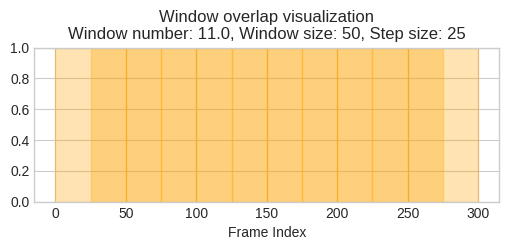

In [117]:
# Run VGGT to estimate camera and depth
# Run with 518x518 images
# process with image batches with appointed overlapping rate
window_size = 50
min_overlap = 0.5  # 50% overlap
window_num = np.ceil((total_frame_num / window_size - 1) / (1 - min_overlap) + 1)
window_step = int(window_size * (total_frame_num / window_size - 1) / (window_num - 1))
start_indices = [i for i in range(0, total_frame_num - window_size + 1, window_step)]
end_indices = [min(i + window_size, total_frame_num) for i in start_indices]
end_indices[-1] = total_frame_num  # Ensure the last window includes all remaining images

# visualize the interval
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(6, 2))
for start, end in zip(start_indices, end_indices):
    plt.axvspan(start, end, color='orange', alpha=0.3)
plt.xlabel('Frame Index')
plt.title(f'Window overlap visualization\nWindow number: {window_num}, Window size: {window_size}, Step size: {window_step}')
plt.legend()
plt.show()

In [ ]:
# Run VGGT in batches
# extrinsic, intrinsic, depth_map, depth_conf = run_VGGT(model, images, dtype, vggt_fixed_resolution)
# points_3d = unproject_depth_map_to_point_map(depth_map, extrinsic, intrinsic)

fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)
translation_gt = torch.tensor([image.tvec for image in images_gt_updated.values()], device=device)
rotation_gt = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_gt_updated.values()], device=device)

gt_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
gt_se3[:, :3, :3] = rotation_gt
gt_se3[:, 3, :3] = translation_gt

extrinsics_list = []
intrinsics_list = []
depth_maps_list = []
depth_conf_list = []
points_3d_list = []
Auc30_list = []
tError_list = []
rError_list = []

for start, end in tqdm(zip(start_indices, end_indices), total=len(start_indices), desc="Processing windows"):
    images_batch = images[start:end]
    extrinsic, intrinsic, depth_map, depth_conf = run_VGGT(model, images_batch, dtype, vggt_fixed_resolution)

    pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(extrinsic), 1, 1)
    pred_se3[:, :3, :3] = torch.tensor(extrinsic[:, :3, :3], device=device)
    pred_se3[:, 3, :3] = torch.tensor(extrinsic[:, :3, 3], device=device)

    rel_rangle_deg, rel_tangle_deg = camera_to_rel_deg(pred_se3, gt_se3[start:end], device, 4)

    rError = rel_rangle_deg.cpu().numpy()
    tError = rel_tangle_deg.cpu().numpy()
    Auc_30 = calculate_auc_np(rError, tError, max_threshold=30)
    Auc30_list.append(Auc_30)
    tError_list.append(tError)
    rError_list.append(rError)
    
    extrinsics_list.append(extrinsic)
    intrinsics_list.append(intrinsic)
    depth_maps_list.append(depth_map)
    depth_conf_list.append(depth_conf)
    
    points_3d = unproject_depth_map_to_point_map(depth_map, extrinsic, intrinsic)
    points_3d_list.append(points_3d)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 5))
plt.plot(start_indices, Auc30_list, marker='o', label='AUC at 30 degrees', color='blue')
plt.xlabel('Window Start Index')
plt.ylabel('AUC at 30 degrees')

In [119]:
# calculate c, R, t of adjacent batches using overlapping images
c_list = []
R_list = []
t_list = []
ext_error_list = []
int_error_list = []
depth_error_list = []
conf_thresh = 0.85  # Confidence threshold for depth map

merged_extrinsics = extrinsics_list[0]
merged_intrinsics = intrinsics_list[0]
merged_depth_maps = depth_maps_list[0]
merged_depth_confs = depth_conf_list[0]
merged_points_3ds = points_3d_list[0]

for i in tqdm(range(1, len(start_indices))):

    window_overlap = end_indices[i-1] - start_indices[i]

    points_3d1 = merged_points_3ds[len(merged_points_3ds)-window_overlap:].reshape(-1, 3)
    # points_3d1 = points_3d_list[i-1][len(points_3d_list[i-1])-window_overlap:].reshape(-1, 3)
    points_3d2 = points_3d_list[i][:window_overlap].reshape(-1, 3)

    # confidence mask
    points_conf1 = merged_depth_confs[len(merged_depth_confs)-window_overlap:].reshape(-1)
    # points_conf1 = depth_conf_list[i-1][len(depth_conf_list[i-1])-window_overlap:].reshape(-1)
    points_conf2 = depth_conf_list[i][:window_overlap].reshape(-1)
    conf_mask = (points_conf1 > conf_thresh) & (points_conf2 > conf_thresh)

    # outlier mask
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d1)
    distances1 = np.array(pcd.compute_nearest_neighbor_distance())
    avg_dist1 = np.mean(distances1)
    std_dev_dist1 = np.std(distances1)
    mask_distance1 = distances1 < avg_dist1 + 2.5 * std_dev_dist1

    pcd.points = o3d.utility.Vector3dVector(points_3d2)
    distances2 = np.array(pcd.compute_nearest_neighbor_distance())
    avg_dist2 = np.mean(distances2)
    std_dev_dist2 = np.std(distances2)
    mask_distance2 = distances2 < avg_dist2 + 2.5 * std_dev_dist2

    mask = conf_mask & mask_distance1 & mask_distance2
    
    c, R, t = umeyama(points_3d2[mask].T, points_3d1[mask].T)
    c_list.append(c)
    R_list.append(R)
    t_list.append(t)

    points2merge = points_3d_list[i][window_overlap:].reshape(-1, 3)
    points2merge = (c * R @ points2merge.T + t).T
    points2merge = points2merge.reshape(points_3d_list[i][window_overlap:].shape)
    merged_points_3ds = np.concatenate([merged_points_3ds, points2merge], axis=0)

    merged_intrinsics = np.concatenate([merged_intrinsics, intrinsics_list[i][window_overlap:]], axis=0)
    merged_depth_maps = np.concatenate([merged_depth_maps, depth_maps_list[i][window_overlap:] * c], axis=0)
    # merged_depth_maps = np.concatenate([merged_depth_maps, depth_maps_list[i][window_size-window_step:]], axis=0)
    merged_depth_confs = np.concatenate([merged_depth_confs, depth_conf_list[i][window_overlap:]], axis=0)

    ext_transform = np.eye(4)
    ext_transform[:3, :3] = R
    ext_transform[:3, 3:] = t
    ext_transform = np.linalg.inv(ext_transform)

    extrinsics2merge = np.zeros((extrinsics_list[i].shape[0], 4, 4))
    extrinsics2merge[:, :3, :4] = extrinsics_list[i]
    extrinsics2merge[:, :3, 3] *= c
    extrinsics2merge[:, 3, 3] = 1.0
    extrinsics2merge = np.einsum('bmn,bnk->bmk', extrinsics2merge, ext_transform[None])

    merged_extrinsics = np.concatenate([merged_extrinsics[:len(merged_extrinsics)-window_overlap], extrinsics2merge[:, :3, :4]], axis=0)

    # points_3d2 = (c * (R @ points_3d2.T) + t).T

    # pcd_src = o3d.geometry.PointCloud()
    # pcd_src.points = o3d.utility.Vector3dVector(points_3d1[mask])

    # pcd_tgt = o3d.geometry.PointCloud()
    # pcd_tgt.points = o3d.utility.Vector3dVector(points_3d2[mask])

    # completeness = pcd_src.compute_point_cloud_distance(pcd_tgt)
    # accuracy = pcd_tgt.compute_point_cloud_distance(pcd_src)

    # chamfer_distance = np.mean(np.concatenate([accuracy, completeness]))

    # print(f"Accuracy: {np.mean(accuracy):.4f}, Completeness: {np.mean(completeness):.4f}, Chamfer Distance: {chamfer_distance:.4f}") 

100%|██████████| 10/10 [01:09<00:00,  7.00s/it]


100%|██████████| 10/10 [00:00<00:00, 78.02it/s]


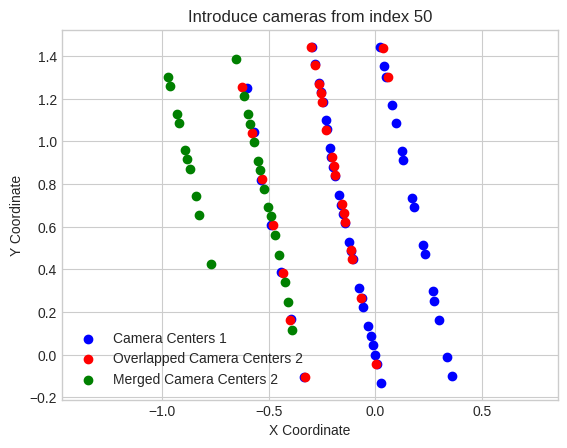

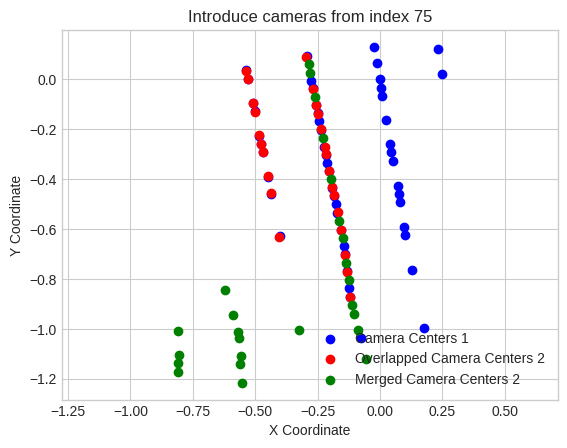

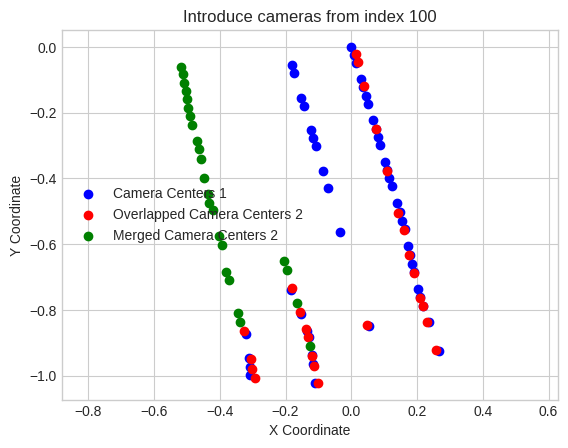

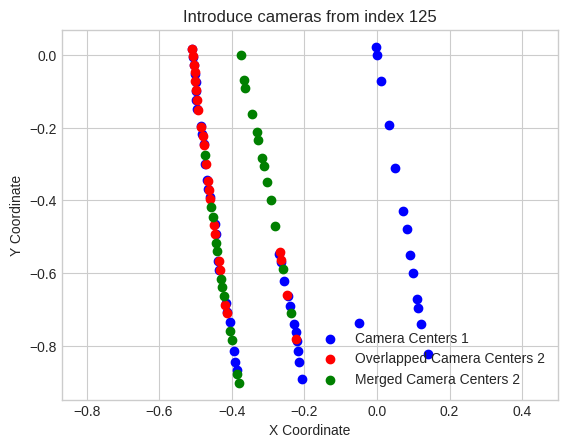

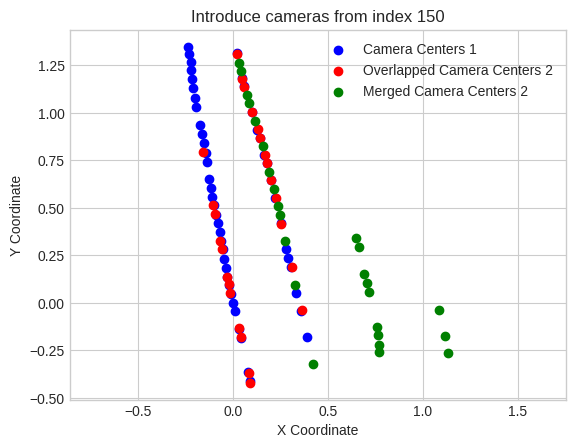

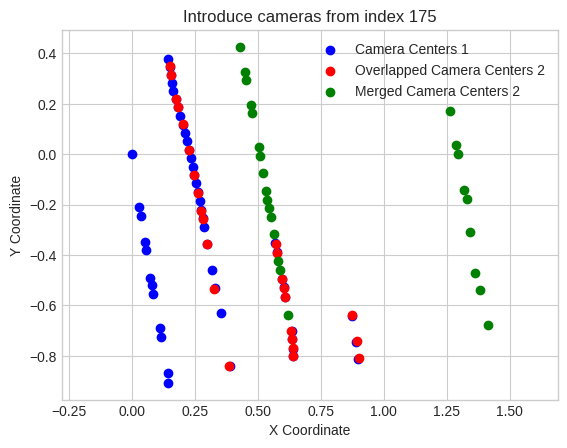

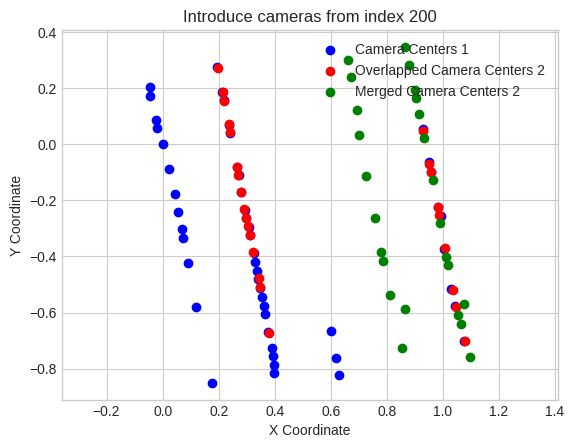

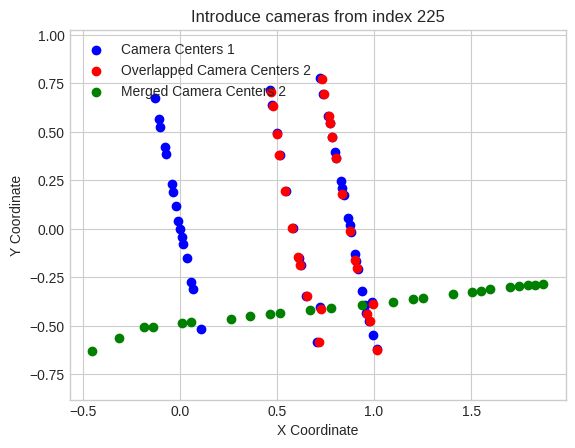

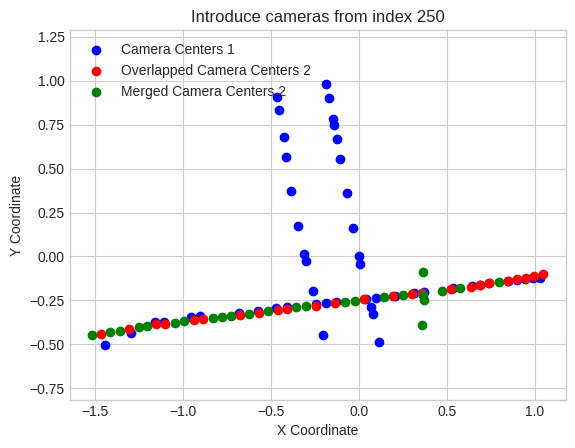

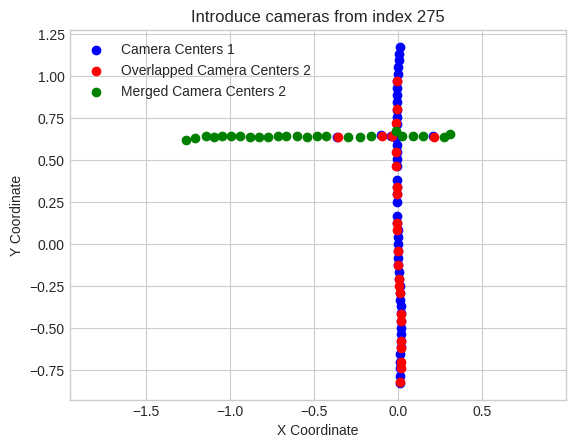

In [120]:
cam_centers1_list = []
cam_centers2_list = []
cam_center_err_list = []
for i in tqdm(range(1, len(start_indices))):
    extrinsics1 = extrinsics_list[i-1]
    extrinsics2 = extrinsics_list[i]

    camera_centers1 = - (extrinsics1[:, :3, :3].transpose(0, 2, 1) @ extrinsics1[:, :3, 3:]).squeeze(-1)
    camera_centers2 = - (extrinsics2[:, :3, :3].transpose(0, 2, 1) @ extrinsics2[:, :3, 3:]).squeeze(-1)

    c, R, t = umeyama(camera_centers2[:window_overlap].T, camera_centers1[len(extrinsics_list[i-1])-window_overlap:].T)

    camera_centers2 = (c * (R @ camera_centers2.T) + t).T

    cam_center_err_list.append(np.mean(np.abs(camera_centers1 - camera_centers2), axis=-1))

    plt.figure()
    plt.axis('equal')
    plt.scatter(camera_centers1[:, 0], camera_centers1[:, 1], c='blue', label='Camera Centers 1')
    plt.scatter(camera_centers2[:window_overlap, 0], camera_centers2[:window_overlap, 1], c='red', label='Overlapped Camera Centers 2')
    plt.scatter(camera_centers2[window_overlap:, 0], camera_centers2[window_overlap:, 1], c='green', label='Merged Camera Centers 2')
    plt.legend()
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Introduce cameras from index {start_indices[i] + window_overlap}')

    cam_centers1_list.append(camera_centers1)
    cam_centers2_list.append(camera_centers2)

cam_centers1 = np.concatenate(cam_centers1_list, axis=0)
cam_centers2 = np.concatenate(cam_centers2_list, axis=0)
cam_center_err = np.concatenate(cam_center_err_list, axis=0)

# plt.figure()
# plt.axis('equal')
# plt.scatter(cam_centers1[:, 0], cam_centers1[:, 1], c='blue', label='Camera Centers 1')
# plt.scatter(cam_centers2[:, 0], cam_centers2[:, 1], c='red', label='Camera Centers 2')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Camera Centers Comparison')

In [122]:
CHECK_UNPROJECTION = False
if CHECK_UNPROJECTION:
    points_rgb_unordered = images[:].permute(0, 2, 3, 1).reshape(-1, 3).cpu().numpy()
    merged_points_3ds_unordered = merged_points_3ds.reshape(-1, 3)
    predicted_points_3d = unproject_depth_map_to_point_map(merged_depth_maps, merged_extrinsics, merged_intrinsics)
    predicted_points_3d_unordered = predicted_points_3d.reshape(-1, 3)

    x_min, x_max = merged_points_3ds_unordered[:, 0].min(), merged_points_3ds_unordered[:, 0].max()
    y_min, y_max = merged_points_3ds_unordered[:, 1].min(), merged_points_3ds_unordered[:, 1].max()

    interval = 100
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # plt.scatter(points_3d1_transformed[::interval, 0], points_3d1_transformed[::interval, 1], c=points_rgb1[::interval], s=1)
    plt.scatter(merged_points_3ds_unordered[::interval, 0], merged_points_3ds_unordered[::interval, 1], c=points_rgb_unordered[::interval], s=1)
    plt.axis('equal')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f"Directly Merged Points")

    plt.subplot(1, 2, 2)
    plt.scatter(predicted_points_3d_unordered[::interval, 0], predicted_points_3d_unordered[::interval, 1], c=points_rgb_unordered[::interval], s=1)
    plt.axis('equal')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f"Regenerated Points")

    --  Pair Rot   Error (Deg) of Vanilla:       8.58
    --  Pair Trans Error (Deg) of Vanilla:      12.01
    --  AUC at 30: 0.7375


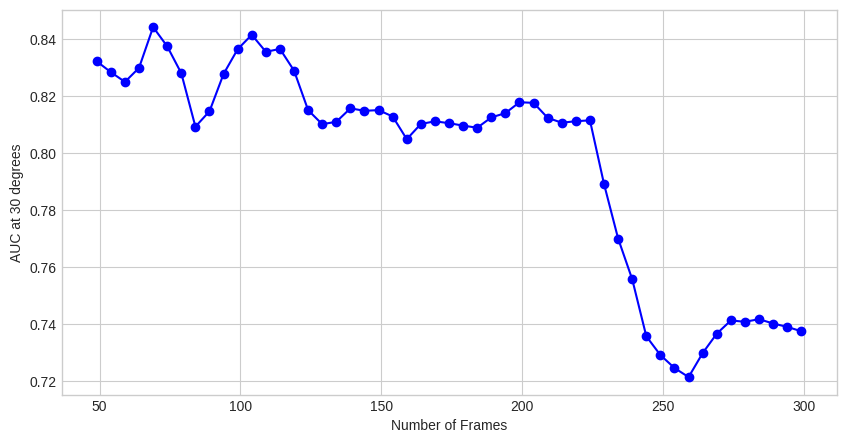

In [123]:
pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(merged_extrinsics[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(merged_extrinsics[:, :3, 3], device=device)

Auc30_list = []
tError_list = []
rError_list = []
for n in range(window_size-1, len(images_gt_updated), 5):

    rel_rangle_deg, rel_tangle_deg = camera_to_rel_deg(pred_se3[:n], gt_se3[:n], device, 4)

    rError = rel_rangle_deg.cpu().numpy()
    tError = rel_tangle_deg.cpu().numpy()
    Auc_30 = calculate_auc_np(rError, tError, max_threshold=30)
    Auc30_list.append(Auc_30)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(window_size-1, len(images_gt_updated), 5), Auc30_list, marker='o', label='AUC at 30 degrees', color='blue')
plt.xlabel('Number of Frames')
plt.ylabel('AUC at 30 degrees')

print(f"    --  Pair Rot   Error (Deg) of Vanilla: {rel_rangle_deg.mean():10.2f}")
print(f"    --  Pair Trans Error (Deg) of Vanilla: {rel_tangle_deg.mean():10.2f}")
print(f"    --  AUC at 30: {Auc_30:.4f}")

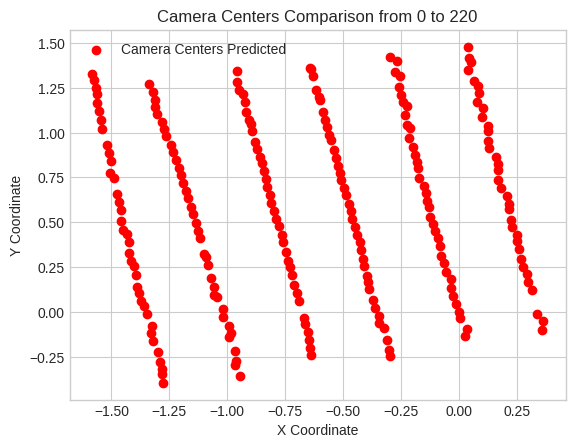

In [124]:
camera_centers_gt = - (gt_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ gt_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
camera_centers_pred = - (pred_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ pred_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)

start_idx, end_idx = 0, 220

plt.figure()
# plt.axis('equal')
# plt.scatter(camera_centers_gt[start_idx:end_idx, 0], camera_centers_gt[start_idx:end_idx, 1], c='blue', label='Camera Centers GT')
plt.scatter(camera_centers_pred[start_idx:end_idx, 0], camera_centers_pred[start_idx:end_idx, 1], c='red', label='Camera Centers Predicted')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Camera Centers Comparison from {start_idx} to {end_idx}')
plt.legend()

In [125]:
pcd_xyz_gt_list = []
pcd_rgb_gt_list = []
pcd_xyz_sampled_list = []
pcd_rgb_sampled_list = []
conf_thresh = 0.5  # Confidence threshold for depth map

for k, idx in tqdm(enumerate(list(images_gt_updated.keys()))):

    # if k < 0 or k >= 50:
    #     continue

    point3D_ids_gt = images_gt_updated[idx].point3D_ids
    mask_gt = (point3D_ids_gt >= 0) & (images_gt_updated[idx].xys[:, 0] >= 0) & (images_gt_updated[idx].xys[:, 1] >= 0) & \
                (images_gt_updated[idx].xys[:, 0] < original_coords[k, -2].item()) & (images_gt_updated[idx].xys[:, 1] < original_coords[k, -1].item())

    xys_gt = images_gt_updated[idx].xys[mask_gt]
    pcd_rgb_gt = np.stack([pcd_gt[id].rgb for id in point3D_ids_gt[mask_gt]], axis=0)
    pcd_xyz_gt = np.stack([pcd_gt[id].xyz for id in point3D_ids_gt[mask_gt]], axis=0)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pcd_xyz_gt)
    distances = np.array(pcd.compute_nearest_neighbor_distance())
    avg_dist = np.mean(distances)
    std_dev_dist = np.std(distances)

    mask_distance = distances < avg_dist + 2.5 * std_dev_dist
    xys_gt = xys_gt[mask_distance]
    pcd_xyz_gt = pcd_xyz_gt[mask_distance]
    pcd_rgb_gt = pcd_rgb_gt[mask_distance]

    # transform xys_gt to the coordinate on points_3d, which is (N, H, W, 3)
    xys_gt_scaled = np.zeros_like(xys_gt)
    pcd_xyz_sampled = np.zeros_like(pcd_xyz_gt)
    pcd_conf_sampled = np.zeros_like(pcd_rgb_gt[:, 0])  # Assuming confidence is a single channel
    pcd_rgb_sampled = np.zeros_like(pcd_rgb_gt)
    resize_ratio = original_coords[:, -2:].max() / vggt_fixed_resolution

    xys_gt_scaled[:, 0] = xys_gt[:, 0] / resize_ratio + original_coords[k, 0]
    xys_gt_scaled[:, 1] = xys_gt[:, 1] / resize_ratio + original_coords[k, 1]
    
    pcd_xyz_sampled = merged_points_3ds[k, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)]
    pcd_conf_sampled = merged_depth_confs[k, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)]
    pcd_rgb_sampled = images[k, :, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)].permute(1, 0).cpu().numpy() * 255

    conf_mask = (pcd_conf_sampled > conf_thresh) & ((pcd_rgb_gt - pcd_rgb_sampled).sum(axis=1) < 10)  # RGB difference threshold

    pcd_xyz_gt_list.append(pcd_xyz_gt[conf_mask])
    pcd_xyz_sampled_list.append(pcd_xyz_sampled[conf_mask])
    pcd_rgb_gt_list.append(pcd_rgb_gt[conf_mask])
    pcd_rgb_sampled_list.append(pcd_rgb_sampled[conf_mask])

c, R, t = umeyama(np.concatenate(pcd_xyz_gt_list, axis=0).T, np.concatenate(pcd_xyz_sampled_list, axis=0).T)

print("Estimated Camera Parameters:")
print(f"Scale (c): {c}")
print(f"Rotation (R):\n{R}")
print(f"Translation (t):\n{t}")

300it [00:10, 29.33it/s]


Estimated Camera Parameters:
Scale (c): 0.016259664997972295
Rotation (R):
[[-0.50934816 -0.0064802   0.86053615]
 [ 0.6417072   0.66341953  0.38481994]
 [-0.5733902   0.74821957 -0.33375313]]
Translation (t):
[[ 0.93363599]
 [ 1.14359902]
 [-1.08571402]]


In [126]:
pcd_xyz_gt_array = np.concatenate(pcd_xyz_gt_list, axis=0)
pcd_xyz_sampled_array = np.concatenate(pcd_xyz_sampled_list, axis=0)
pcd_rgb_gt_array = np.concatenate(pcd_rgb_gt_list, axis=0) / 255.0
pcd_rgb_sampled_array = np.concatenate(pcd_rgb_sampled_list, axis=0) / 255.0

pcd_xyz_gt_array = (c * (R @ pcd_xyz_gt_array.T) + t).T

pcd_src = o3d.geometry.PointCloud()
pcd_src.points = o3d.utility.Vector3dVector(pcd_xyz_gt_array)
pcd_src.colors = o3d.utility.Vector3dVector(pcd_rgb_gt_array)

pcd_tgt = o3d.geometry.PointCloud()
pcd_tgt.points = o3d.utility.Vector3dVector(pcd_xyz_sampled_array)
pcd_tgt.colors = o3d.utility.Vector3dVector(pcd_rgb_sampled_array)

completeness = pcd_src.compute_point_cloud_distance(pcd_tgt)
accuracy = pcd_tgt.compute_point_cloud_distance(pcd_src)

chamfer_distance = np.mean(np.concatenate([accuracy, completeness]))

print(f"Accuracy: {np.mean(accuracy)}") 
print(f"Completeness: {np.mean(completeness)}")
print(f"Chamfer Distance: {chamfer_distance}")

Accuracy: 0.008830718872848635
Completeness: 0.004493621389744008
Chamfer Distance: 0.006662170131296327


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


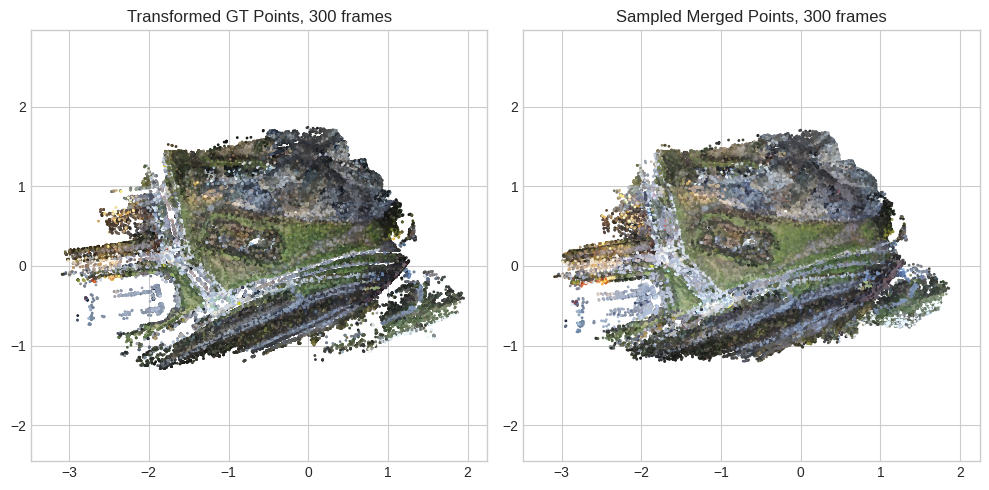

In [127]:
ANALYZE_RESULT=True
if ANALYZE_RESULT:
    x_min, x_max = pcd_xyz_sampled_array[:, 0].min(), pcd_xyz_sampled_array[:, 0].max()
    y_min, y_max = pcd_xyz_sampled_array[:, 1].min(), pcd_xyz_sampled_array[:, 1].max()

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(pcd_xyz_gt_array[:, 0], pcd_xyz_gt_array[:, 1], c=pcd_rgb_gt_array, s=1)
    plt.axis('equal')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f"Transformed GT Points, {total_frame_num} frames")

    plt.subplot(1, 2, 2)
    plt.scatter(pcd_xyz_sampled_array[:, 0], pcd_xyz_sampled_array[:, 1], c=pcd_rgb_sampled_array, s=1)
    plt.axis('equal')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f"Sampled Merged Points, {total_frame_num} frames")

    plt.tight_layout()